In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy.optimize as op
from datetime import datetime

import os
from pandas.tseries.offsets import BDay

## a) Loading the return series

In [2]:
ret_file = os.path.join('MFE_DAM', 'Data', 'US.csv')
us_ret = pd.read_csv(ret_file, parse_dates=[0], index_col=[0], na_values=[0])
us_ret = us_ret.fillna(method='ffill')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BFC80A0C88>,
      dtype=object)

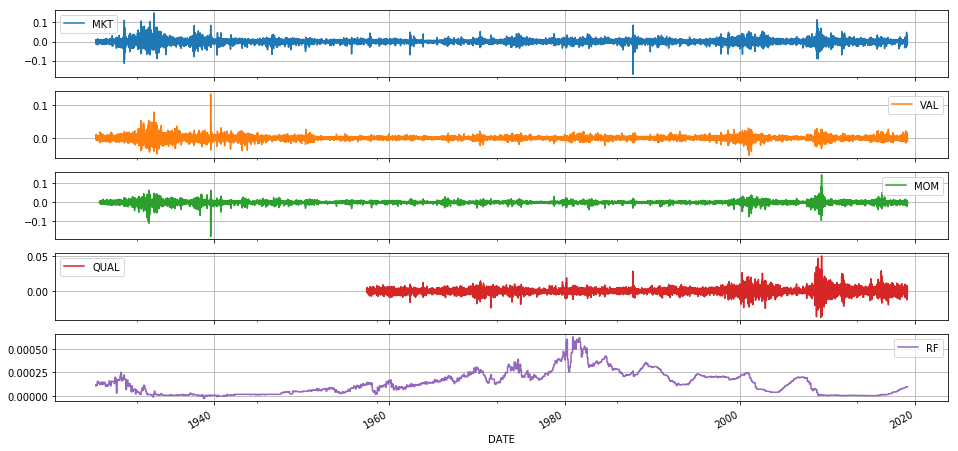

In [3]:
us_ret.plot(figsize=(16,8), grid=True, subplots=True)

In [4]:
us_Price = (us_ret+1).cumprod().shift(1)
for col in us_Price.columns:
    lastNanRow = max(np.where(us_Price[col].isnull())[0])
    us_Price.loc[us_Price.index[lastNanRow],col] = 1
us_Price

,MKT,VAL,MOM,QUAL,RF
DATE,,,,,
1926-07-31,1.000000,1.000000,NaN,NaN,1.000000
1926-08-02,1.004327,1.000119,NaN,NaN,1.000106
1926-08-03,1.012653,1.001592,NaN,NaN,1.000226
1926-08-04,1.017484,0.999310,NaN,NaN,1.000346
1926-08-05,1.013819,1.000493,NaN,NaN,1.000466
1926-08-06,1.012916,1.007472,NaN,NaN,1.000586
1926-08-07,1.019714,1.009039,NaN,NaN,1.000706
1926-08-09,1.024276,1.007618,NaN,NaN,1.000826
1926-08-10,1.026235,1.006002,NaN,NaN,1.000946


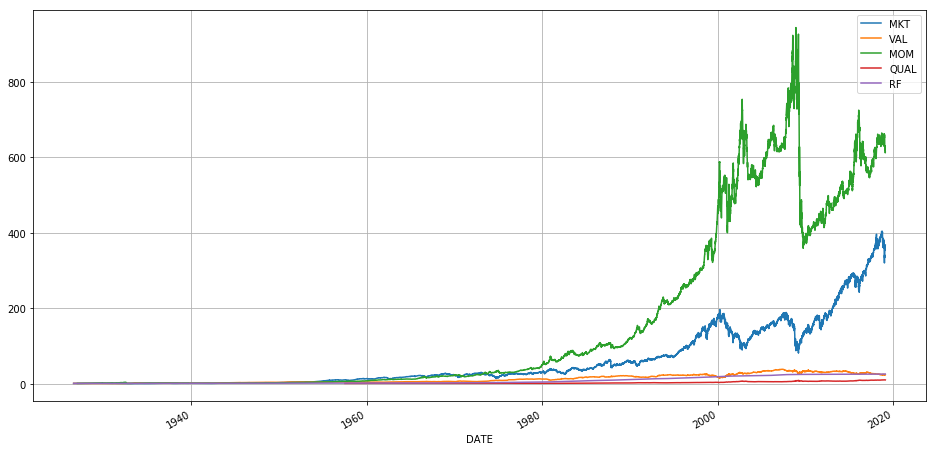

In [5]:
us_Price.plot(figsize=(16,8), grid=True, subplots=False)

## b) Functions definition

In [6]:
def convertIR2Weights(ir_df, day_lag = 0):
    """
    Function to calculate the factor weights from the IR series.
    The frequency is the same as ir_df
    """
    # omit Rf bond because its w is too small
    df = ir_df.drop(columns=['RF'], inplace=False)
    
    weights = pd.DataFrame(columns = df.columns, index = df.index)
    tmp_Sum = df.sum(axis=1)
    for col in weights.columns:
        weights[col] = df[col]/tmp_Sum
    weights.fillna(0, inplace=True)
    weights.index = weights.index + BDay(day_lag)
    return weights

In [7]:
def convertWeights2Shares(weights, df_Price, GMV, Tcost_vec):
    """
    Tcost considered
    """
    turnover = 0
    shares = pd.DataFrame(columns = weights.columns, index = weights.index)
    idx = weights.index
    asset_Price = df_Price.reindex(columns=weights.columns)

    shares.loc[idx[0],:] = GMV*weights.loc[idx[0],:]/asset_Price.loc[idx[0],:]
    for i in range(1,len(idx)):
        if abs(weights.loc[idx[i],:].sum()) < 1e-10:
            shares.loc[idx[i],:] = shares.loc[idx[i-1],:]
        else:
            val_wo_rebalance = shares.loc[idx[i-1],:]*asset_Price.loc[idx[i],:]
            GMV_wo_rebalance = val_wo_rebalance.sum()
            val_before_Tcost = GMV_wo_rebalance*weights.loc[idx[i],:]
            val_abs_diff = val_before_Tcost.subtract(val_wo_rebalance, fill_value=0).abs()
            cost = (val_abs_diff*Tcost_vec).sum()
            val_after_Tcost = (GMV_wo_rebalance-cost)*weights.loc[idx[i],:]
            shares.loc[idx[i],:] = val_after_Tcost/asset_Price.loc[idx[i],:]
            turnover += cost
    return (shares, turnover)

In [8]:
def df2Daily(df, idx):
    """
    Change the weights frequency into daily basis
    Forward fill the inbetween elements
    """
    df_daily = pd.DataFrame(index = idx)
    for col in df.columns:
        df_daily[col] = df[col]
    df_daily.fillna(method='ffill',inplace=True)
    return df_daily

In [9]:
def calcPnl(df_Price, shares_daily):
    price_reindexed = df_Price.reindex(columns=shares_daily.columns)
    pnl = shares_daily*price_reindexed.values
    nonNanRow = min(np.where((~pnl.isnull()).any(axis=1))[0])
    pnl = pnl.sum(axis=1)
    pnl.iloc[:nonNanRow] = np.nan
    pnl = pnl/pnl[nonNanRow]-1
    pnl.dropna(inplace=True)
    return (pnl, nonNanRow)

In [10]:
def cumul_perf(ret):
    """
    Function to calculate the cumulative excess return series
    """
    return ((1 + ret).cumprod(axis=0)) - 1

In [11]:
def SR(pnl):
    pnl_diff = pnl.diff()
    pnl_diff.dropna(inplace=True)
    rsl = np.sqrt(252)*pnl_diff.mean()/pnl_diff.std(ddof=0)
    return rsl

In [35]:
def maxDrawDown(pnl):
    T = pnl.iloc[0]
    Vmin = pnl.iloc[0]
    Tmax = max(0.,T)
    for i in range(1,len(pnl)):
        T = pnl.iloc[i]
        if T-Tmax < Vmin:
            Vmin = T-Tmax
        if T>Tmax:
            Tmax = T
    return Vmin

In [13]:
def calc_Tcost(ir_df, weights, tcost_vec):
    """
    Obselete
    Assume the strategy rebalanced at the same frequency as ir_df
    Calculate the trading cost
    """
    ret = 1+ir_df
    ret['Group'] = np.nan
    # ret.loc[weights.index, 'Group'] = np.array(range(1,weights.shape[0]+1))
    ret['Group'] = pd.Series(range(1,weights.shape[0]+1), index=weights.index)
    ret['Group'].fillna(method='ffill', inplace=True)
    ret['Group'].fillna(0, inplace=True)
    ret_yearly = ret.groupby(['Group']).prod()
    ret_yearly.drop(ret_yearly.index[0], axis=0, inplace=True)
    
    ret_yearly.index = weights.index
    ret_yearly[ret_yearly==1.] = np.nan
    ret_yearly = ret_yearly.reindex(columns=weights.columns)
    tmp_port = weights*ret_yearly.values
    tmp_Sum = tmp_port.sum(axis=1)
    
    w_wo_rebalance = pd.DataFrame(columns = weights.columns, index = weights.index)
    for col in weights.columns:
        w_wo_rebalance[col] = tmp_port[col]/tmp_Sum
    w_wo_rebalance = w_wo_rebalance.shift(1)
    w_wo_rebalance.iloc[0] = weights.iloc[0]
    w_abs_diff = weights.subtract(w_wo_rebalance, fill_value=0).abs()
    Tcost = w_abs_diff.dot(tcost_vec)
    return Tcost

In [14]:
def calc_ret(ir_df, weights, weights_daily, tcost_vec):
    """
    Obselete
    Taking into account the trading cost, calculate the portfolio daily return series
    """
    ir_reordered = ir_df.reindex(columns=weights_daily.columns)
    tmp_df = weights_daily*ir_reordered.values
    nonNanRow = min(np.where((~tmp_df.isnull()).any(axis=1))[0])
    rets = tmp_df.sum(axis=1)
    rets.iloc[:nonNanRow] = np.nan
    
    Tcost = calc_Tcost(ir_df, weights, tcost_vec)
    rets[Tcost.index] = rets[Tcost.index] - Tcost.values
    return (rets, nonNanRow)

## a) Yearly IR series

In [15]:
IR_year = os.path.join('MFE_DAM', 'US_IR_wrt_mkt_year.csv')
ir_mkt_year = pd.read_csv(IR_year, parse_dates=[0], index_col=[0], na_values=[0])
ir_mkt_year = ir_mkt_year.asfreq('Y', method='ffill').fillna(method='ffill')
ir_mkt_year[ir_mkt_year<0] = 0

In [16]:
ir_mkt_year.loc[ir_mkt_year.isnull().any(axis=1)]

,MOM,QUAL,RF,VAL
1926-12-31,NaN,NaN,0.710444,0.011591
1927-12-31,0.004052,NaN,0.458107,0.000000
1928-12-31,0.004426,NaN,0.193574,0.000000
1929-12-31,0.008219,NaN,0.397795,0.005514
1930-12-31,0.005484,NaN,0.140992,0.000000
1931-12-31,0.000129,NaN,0.117255,0.000000
1932-12-31,0.000000,NaN,0.056249,0.003681
1933-12-31,0.000000,NaN,0.051433,0.001279
1934-12-31,0.003061,NaN,0.075438,0.000000
1935-12-31,0.006527,NaN,0.179379,0.000000


In [17]:
GMV = 1e6
Tcost_vec = np.array([50e-4,50e-4,50e-4])

weights = convertIR2Weights(ir_mkt_year, day_lag = 1)
(shares, turnover) = convertWeights2Shares(weights, us_Price, GMV, Tcost_vec)
shares_daily = df2Daily(shares, us_Price.index)
shares

,MOM,QUAL,VAL
1927-01-03,0,NaN,931289
1928-01-02,790780,NaN,0
1929-01-01,790780,NaN,0
1930-01-01,471346,NaN,570944
1931-01-01,671869,NaN,0
1932-01-01,671869,NaN,0
1933-01-02,0,NaN,917622
1934-01-01,0,NaN,917622
1935-01-01,739766,NaN,0
1936-01-01,739766,NaN,0


In [18]:
turnover

8299414.822528445

In [19]:
perf, nonNanRow = calcPnl(us_Price, shares_daily)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

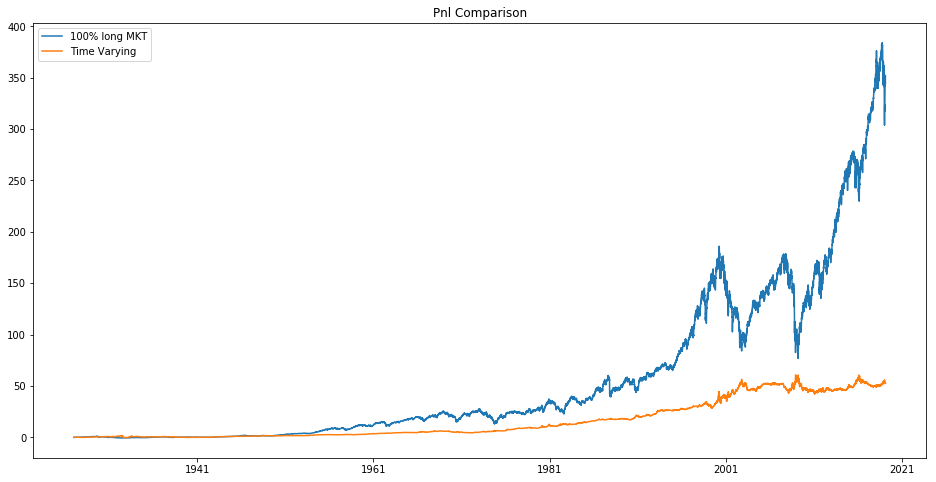

In [20]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

In [21]:
SR(perf)

0.24621682258364933

In [22]:
SR(perf_MKT)

0.24078616253424673

## Monthly IR Series

In [23]:
IR_month = os.path.join('MFE_DAM', 'US_IR_wrt_mkt_month.csv')
ir_mkt_month = pd.read_csv(IR_month, parse_dates=[0], index_col=[0], na_values=[0])
ir_mkt_month = ir_mkt_month.asfreq('M', method='ffill').fillna(method='ffill')
ir_mkt_month[ir_mkt_month<0] = 0

nonNanRow = min(np.where((~ir_mkt_month.isnull()).any(axis=1))[0])
ir_mkt_month = ir_mkt_month.iloc[nonNanRow:,]

In [24]:
ir_mkt_month.loc[ir_mkt_month.isnull().any(axis=1)]

,MOM,QUAL,RF,VAL
1926-08-31,NaN,NaN,NaN,0.095609
1926-09-30,NaN,NaN,NaN,0.000000
1926-10-31,NaN,NaN,NaN,0.041203
1926-11-30,NaN,NaN,NaN,0.011927
1926-12-31,NaN,NaN,NaN,0.000000
1927-01-31,0.081586,NaN,NaN,0.062117
1927-02-28,0.000000,NaN,NaN,0.039361
1927-03-31,0.098398,NaN,NaN,0.000000
1927-04-30,0.057460,NaN,NaN,0.008879
1927-05-31,0.054696,NaN,NaN,0.064279


In [25]:
weights = convertIR2Weights(ir_mkt_month, day_lag = 1)
weights.drop(weights.index[-1], axis=0, inplace=True)
(shares, turnover) = convertWeights2Shares(weights, us_Price, GMV, Tcost_vec)
shares_daily = df2Daily(shares, us_Price.index)
shares

,MOM,QUAL,VAL
1926-09-01,NaN,NaN,948763
1926-10-01,NaN,NaN,948763
1926-11-01,NaN,NaN,948763
1926-12-01,NaN,NaN,948763
1927-01-03,NaN,NaN,948763
1927-02-01,589104,NaN,407786
1927-03-01,0,NaN,924229
1927-04-01,976254,NaN,0
1927-05-02,844464,NaN,125244
1927-06-01,445514,NaN,509942


In [26]:
turnover

25677048.09035318

In [27]:
perf, nonNanRow = calcPnl(us_Price, shares_daily)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

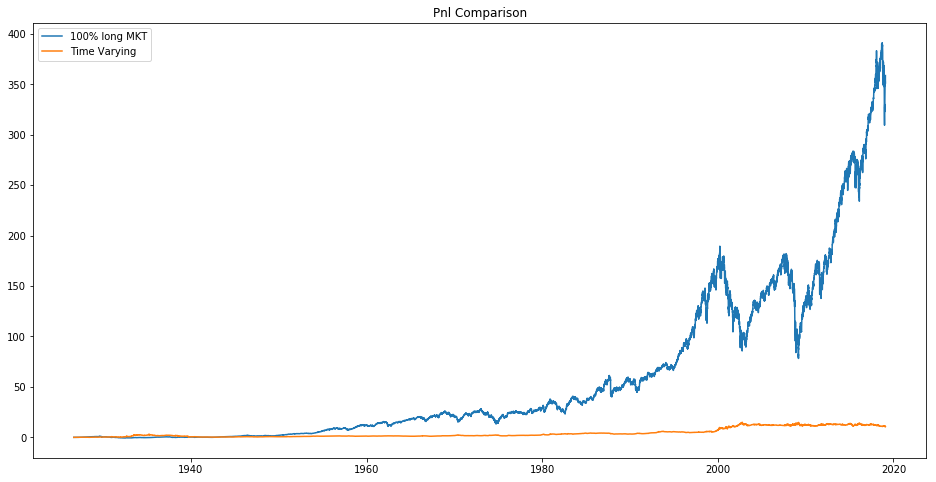

In [28]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

In [29]:
SR(perf)

0.17117678771641176

In [30]:
SR(perf_MKT)

0.24029842672630977

In [36]:
maxDrawDown(perf)/perf.iloc[-1]

-0.4194350244068316

In [37]:
maxDrawDown(perf_MKT)/perf_MKT.iloc[-1]

-0.3102278736052028

In [38]:
maxDrawDown(perf)

-4.440846789538833

In [39]:
maxDrawDown(perf_MKT)

-111.27914948910015